## Diagnostics for approximate likelihood ratios

Kyle Cranmer, Juan Pavez, Gilles Louppe, March 2016.

This is an extension of the example in [Parameterized inference from multidimensional data](./Parameterized%20inference%20from%20multidimensional%20data.ipynb). 
To aid in visualization, we restrict to a 1-dimensional slice of
the likelihood along $\alpha$ with $\beta=-1$.   We consider three situations: i)
a poorly trained, but well calibrated classifier; ii) a well trained, but poorly
calibrated classifier; and iii) a well trained, and well calibrated classifier.
For each case, we employ two diagnostic tests. The first checks for independence
of $-2\log\Lambda(\theta)$ with respect to changes in the reference value
$\theta_1$. The second uses a
classifier to distinguish between samples from  $p(\mathbf{x}|\theta_0)$ and
samples from $p(\mathbf{x}|\theta_1)$ weighted according to $r(\mathbf{x};
\theta_0, \theta_1)$. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.set_cmap("viridis")

import numpy as np
import theano
from scipy.stats import chi2
from itertools import product

np.random.seed(314)

Create model and generate artificial dataset

In [9]:
from carl.distributions import Join
from carl.distributions import Mixture
from carl.distributions import Normal
from carl.distributions import Exponential
from carl.distributions import LinearTransform
from sklearn.datasets import make_sparse_spd_matrix

import pdb

# Parameters
true_A = 1.
A = theano.shared(true_A, name="A")

# Build simulator
R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7)

p0 = LinearTransform(Join(components=[
        Normal(mu=1, sigma=1),
        Normal(mu=-1, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

p1 = LinearTransform(Join(components=[
        Normal(mu=0, sigma=1),
        Normal(mu=0, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)


# Draw data
X_true = p0.rvs(500, random_state=314) 

In [75]:
n_samples = 50000
X0 = p0.rvs(n_samples,random_state=777)
X1 = p1.rvs(n_samples,random_state=777)

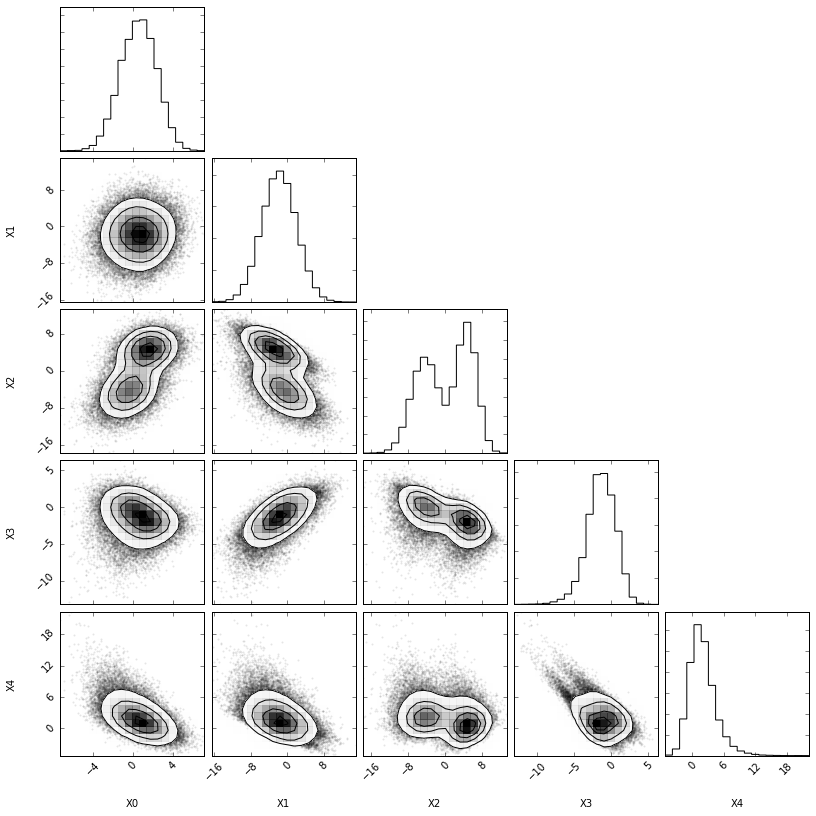

In [11]:
#plot the data
import corner
fig = corner.corner(X0, bins=20, smooth=0.85, labels=["X0", "X1", "X2", "X3", "X4"])
#plt.savefig("fig3.pdf")

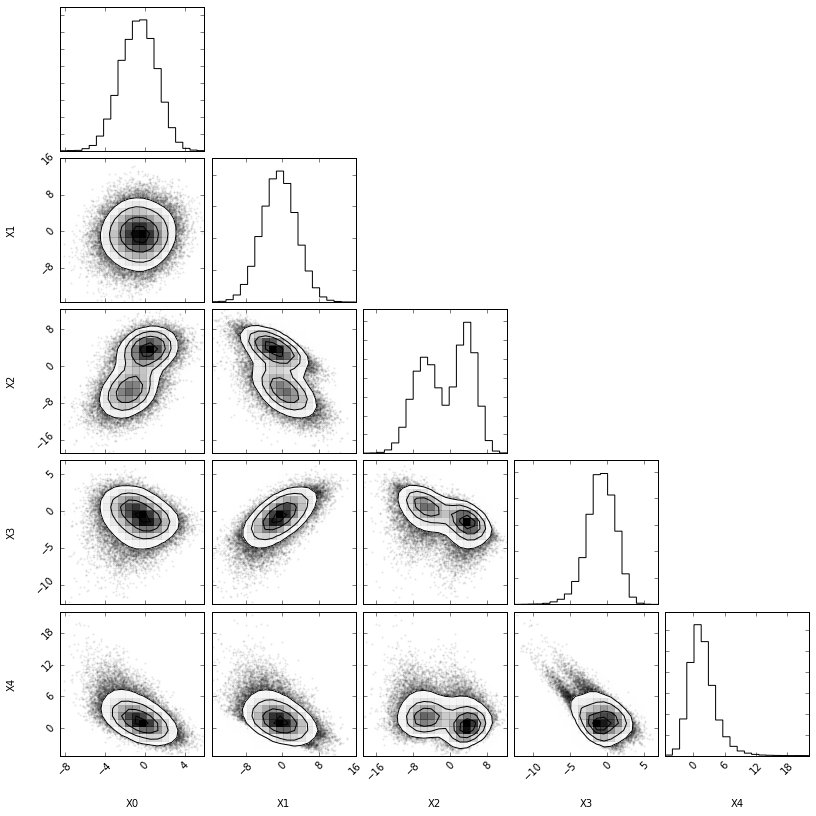

In [12]:
fig = corner.corner(X1, bins=20, smooth=0.85, labels=["X0", "X1", "X2", "X3", "X4"])

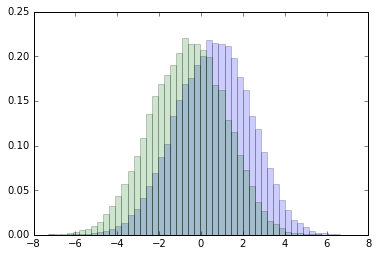

In [17]:
h = plt.hist(X0[:,0], bins=50, normed=True, alpha=0.2)
h = plt.hist(X1[:,0], bins=h[1], normed=True, alpha=0.2)

-27420.168184906444

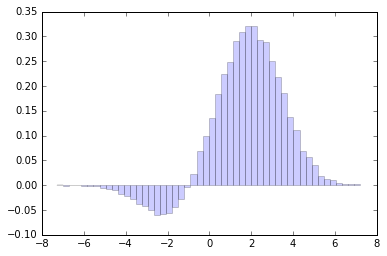

In [18]:
weights0 = p0.nnlf(X0) - p1.nnlf(X0)
h = plt.hist(X0[:,0], bins=50, normed=True, alpha=0.2, weights=weights0)
np.sum(weights0)


In [20]:
from hep_ml import reweight

In [60]:
hist_settings = {'bins': 50, 'normed': True, 'alpha': 0.3}
def draw_distributions(new_original_weights):
    columns = range(5)
    for id, column in enumerate(columns, 1):
        xlim = np.percentile(np.hstack(X1[:,column]), [0.01, 99.99])
        plt.subplot(2,3, id)
        plt.hist(X0[:,column], weights=new_original_weights, range=xlim, color='b',**hist_settings)
        plt.hist(X1[:,column], range=xlim, color='orange',**hist_settings)

In [52]:
reweighter = reweight.GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=1000, 
                                   gb_args={'subsample': 0.6})
reweighter.fit(X0, X1)

gb_weights = reweighter.predict_weights(X0)


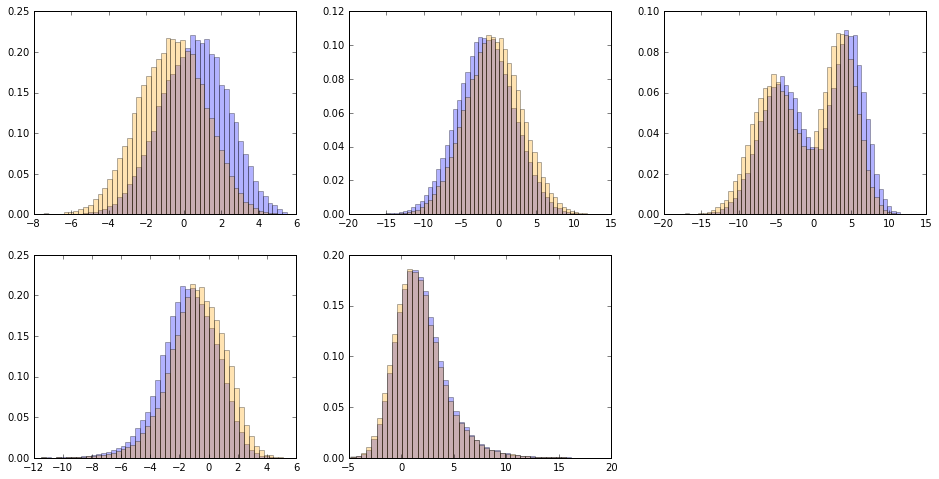

In [61]:
plt.figure(figsize=(16, 8))
draw_distributions(np.ones(weights0.size))

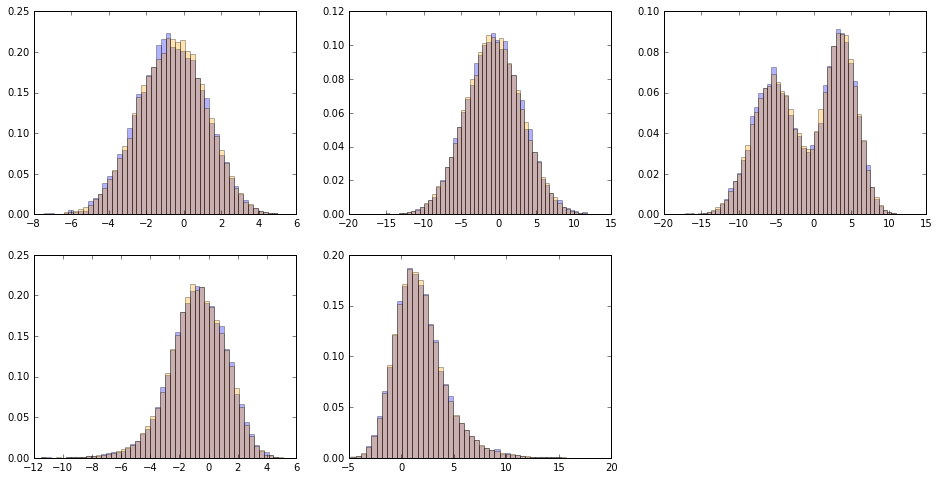

In [62]:
plt.figure(figsize=(16, 8))
draw_distributions(np.exp(weights0))

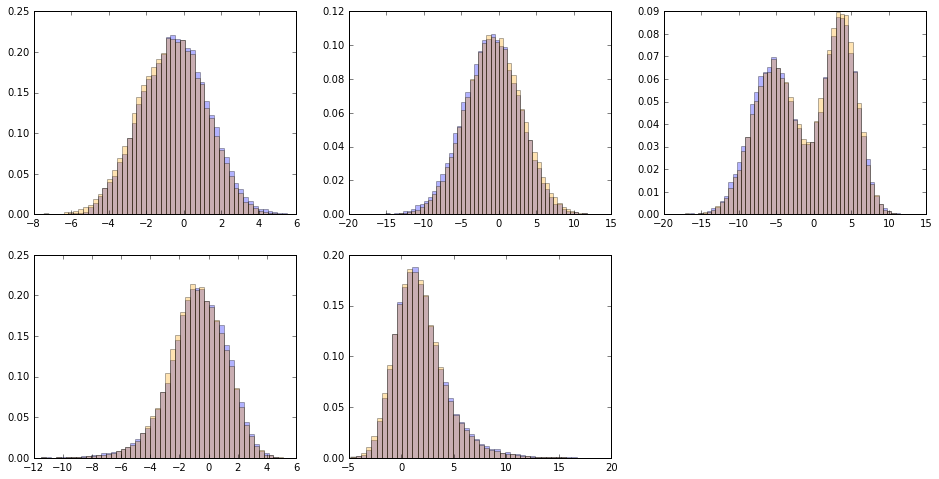

In [63]:
plt.figure(figsize=(16, 8))
draw_distributions(gb_weights)

(0, 1)

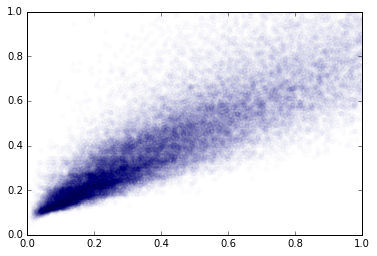

In [71]:
plt.scatter(np.exp(weights0), gb_weights, alpha=0.01)
plt.xlim(0,1)
plt.ylim(0,1)

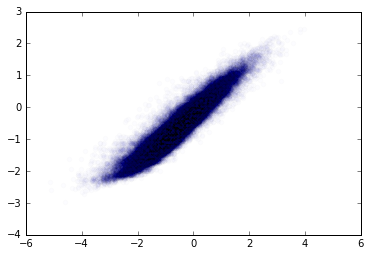

In [70]:
plt.scatter(weights0, np.log(gb_weights), alpha=0.01)

# Likelihood-free setup
Here we create the data to train a parametrized classifier

In [73]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNetCV
from carl.ratios import ClassifierRatio
from carl.ratios import DecomposedRatio
from carl.learning import CalibratedClassifierCV

In [80]:
clf = MLPRegressor(tol=1e-05, activation="logistic", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", algorithm="l-bfgs", random_state=1, 
                   max_iter=75)  # use 15 and 12 bins

cv = StratifiedShuffleSplit(n_iter=1, test_size=0.5, random_state=1)
cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=15, cv=cv), 
    random_state=0)
cc_direct.fit(numerator=p1, denominator=p0, n_samples=n_samples)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=MLPRegressor(activation='logistic', algorithm='l-bfgs', alpha=0.0001,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(10, 10),
       learning_rate='constant', learning_rate_init=...andom_state=1, test_size=0.5,
            train_size=None),
            eps=0.1, method='histogram'),
        random_state=0)

In [81]:
carl_weights = cc_direct.predict(X0)

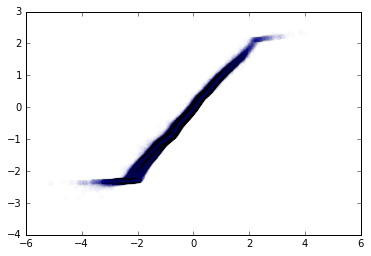

In [82]:
plt.scatter(weights0, np.log(carl_weights), alpha=0.01)

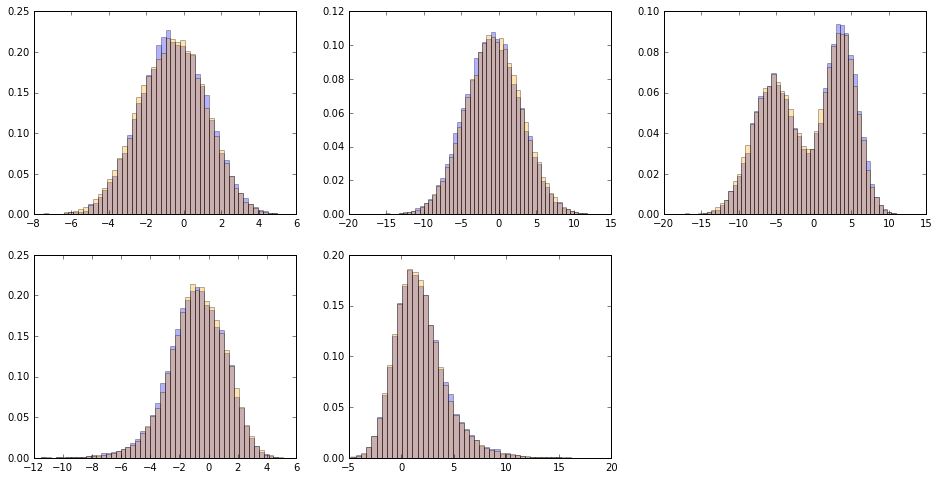

In [84]:
plt.figure(figsize=(16, 8))
draw_distributions(carl_weights)

Now we use a Bayesian optimization procedure to create a smooth surrogate of the approximate likelihood.

## The second diagnostic - ROC curves for a discriminator

In [86]:
from sklearn.metrics import roc_curve, auc
def makeROC(predictions,targetdata):
    fpr, tpr, _  = roc_curve(targetdata.ravel(),predictions.ravel())
    roc_auc = auc(fpr, tpr)
    return fpr,tpr,roc_auc

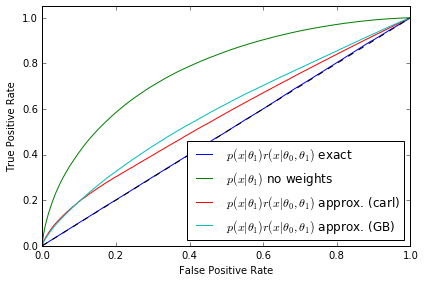

In [92]:
#fig = plt.figure(figsize=(15,15))

# I obtain data from r*p1 by resampling data from p1 using r as weights
def weight_data(x1,x0,weights):
    x1_len = x1.shape[0]
    weights = weights / weights.sum()
    weighted_data = np.random.choice(range(x1_len), x1_len, p = weights)
    w_x1 = x1.copy()[weighted_data]
    y = np.zeros(x1_len * 2)
    x_all = np.vstack((w_x1,x0))
    y_all = np.zeros(x1_len * 2)
    y_all[x1_len:] = 1
    return (x_all,y_all)

X0_roc = p0.rvs(500000,random_state=777)
X1_roc = p1.rvs(500000,random_state=777)

#fig.add_subplot(3,2,(k+1)*2)

ratio = cc_direct

# Weighted with true ratios
true_r = np.exp(p0.nnlf(X0_roc) - p1.nnlf(X0_roc))
true_r[np.isinf(true_r)] = 0.
true_weighted = weight_data(X0_roc,X1_roc,true_r)

# Weighted with approximated ratios
app_r = ratio.predict(X1_roc,log=False)
app_r[np.isinf(app_r)] = 0.
app_weighted = weight_data(X0_roc,X1_roc,app_r)

# Weighted with approximated ratios
gb_app_r = reweighter.predict_weights(X1_roc)
gb_app_r[np.isinf(gb_app_r)] = 0.
gb_app_weighted = weight_data(X0_roc,X1_roc,gb_app_r)


clf_true = MLPRegressor(tol=1e-05, activation="logistic", 
               hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
               learning_rate="constant", algorithm="l-bfgs", random_state=1, 
               max_iter=75)
clf_true.fit(true_weighted[0],true_weighted[1])
predicted_true = clf_true.predict(true_weighted[0])
fpr_t,tpr_t,roc_auc_t = makeROC(predicted_true, true_weighted[1])
plt.plot(fpr_t, tpr_t, label=r"$p(x|\theta_1)r(x|\theta_0,\theta_1)$ exact" % roc_auc_t)

clf_true.fit(np.vstack((X0_roc,X1_roc)),true_weighted[1])
predicted_true = clf_true.predict(np.vstack((X0_roc,X1_roc)))
fpr_f,tpr_f,roc_auc_f = makeROC(predicted_true, true_weighted[1])
plt.plot(fpr_f, tpr_f, label=r"$p(x|\theta_1)$ no weights" % roc_auc_f)

clf_true.fit(app_weighted[0],app_weighted[1])
predicted_true = clf_true.predict(app_weighted[0])
fpr_a,tpr_a,roc_auc_a = makeROC(predicted_true, app_weighted[1])
plt.plot(fpr_a, tpr_a, label=r"$p(x|\theta_1)r(x|\theta_0,\theta_1)$ approx. (carl)" % roc_auc_a)

clf_true.fit(app_weighted[0],gb_app_weighted[1])
predicted_true = clf_true.predict(gb_app_weighted[0])
fpr_a,tpr_a,roc_auc_a = makeROC(predicted_true, gb_app_weighted[1])
plt.plot(fpr_a, tpr_a, label=r"$p(x|\theta_1)r(x|\theta_0,\theta_1)$ approx. (GB)" % roc_auc_a)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()

plt.show()
    
#plt.tight_layout()
#plt.savefig('all_comp.pdf'.format(k))

The ROC curves tell a
similarly revealing story. As expected, the classifier is not able to
distinguish between the distributions when $p(\mathbf{x}|\theta_1)$ is weighted
by the exact likelihood ratio. We can also rule out that this is a deficiency in
the classifier because the two distributions are well separated when no weights
are applied to $p(\mathbf{x}|\theta_1)$. In both the first and second examples the ROC curve correctly diagnoses deficiencies in the
approximate likelihood ratio  $\hat{r}(\hat{s}(\mathbf{x}; \theta_0,
\theta_1))$. Finally, third example shows that the ROC curve in the well
trained, well calibrated case is almost identical with the exact likelihood
ratio, confirming the quality of the approximation.